In [2]:
import sys
sys.path.insert(0,'/data/emiln/VIMOS_AGN/analysis/')
from redshift_analysis.analysis_modules import plotfit4 as pf

import numpy as np
import pandas as pd
import matplotlib
import re
import matplotlib.pyplot as plt
from scipy import ndimage
from astropy.io import fits
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import table
from astropy import wcs
import emcee
from __future__ import division
from astropy.cosmology import WMAP7
import redshift_analysis.analysis_modules.create_catalog as cc
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Make plots readable
params = {'legend.fontsize': 18,
	  'figure.figsize': (6,5),
	 'axes.labelsize': 22,
	 'axes.titlesize':22,
	 'xtick.labelsize':18,
	 'ytick.labelsize':18}
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
fitdf = pd.read_csv('/data/emiln/XLSSU122/ID_z_Chi_Dof_ChiDof_FIRST_GUESS_uniq.txt',delimiter=' ',header=None,names=['ID','z','chi2','DOF','chi2DOF'])
filename = '/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci_spec_extract.cat'
dat = ascii.read(filename)
sdf = pd.DataFrame(dat.as_array())
sdf

def compute_r_center(row):
    c_ra = 34.434125
    c_dec = -3.7587388
    cr500 = 35 #''
    return np.sqrt(np.square(row.X_WORLD-c_ra)+np.square(row.Y_WORLD-c_dec))*3600./cr500 # units of r500

sdf['r_center'] = sdf.apply(compute_r_center,axis=1)
sdf['r_center']


zthresh=0.03
mergedf = fitdf.merge(sdf,how='inner',left_on='ID',right_on='NUMBER')
print len(fitdf)
print len(mergedf)
members = mergedf[(abs(mergedf['z']-1.98)<zthresh) & (mergedf['MAG_AUTO']<24)]
print len(members)
members.columns.values
members['X_WORLD']
members['Y_WORLD']

1207
1207
32


36     -3.749924
54     -3.750172
68     -3.749538
79     -3.749307
148    -3.747747
234    -3.745001
384    -3.738760
396    -3.772856
463    -3.770359
513    -3.767948
516    -3.768007
560    -3.766667
600    -3.765819
622    -3.765614
640    -3.764467
655    -3.764226
661    -3.763513
675    -3.763720
699    -3.763179
736    -3.758796
757    -3.762474
810    -3.760298
813    -3.760700
859    -3.757658
919    -3.758680
933    -3.758259
937    -3.758034
1013   -3.756092
1052   -3.754887
1100   -3.753066
1124   -3.753143
1177   -3.751946
Name: Y_WORLD, dtype: float64

In [5]:
OIII_df = pd.read_csv('/data/emiln/XLSSU122/greped_oiii',delimiter=' ',header=None,names=['ID','LINE','SOMETHING','OIII_LOWER','OIII_MEAN','OIII_UPPER'])
OIII_df['ID'] = OIII_df['ID'].str.split('_').str[0]
OIII_df
Hb_df = pd.read_csv('/data/emiln/XLSSU122/greped_hb',delimiter=' ',header=None,names=['ID','LINE','SOMETHING','Hb_LOWER','Hb_MEAN','Hb_UPPER'])
Hb_df['ID'] = Hb_df['ID'].str.split('_').str[0]
Hb_df
OIII_df['OIII_low_sigma'] = OIII_df['OIII_MEAN'] - OIII_df['OIII_LOWER']
Hb_df['Hb_low_sigma'] = Hb_df['Hb_MEAN'] - Hb_df['Hb_LOWER']
n=3
OIII_df_filtered = OIII_df[(OIII_df['OIII_MEAN']-n*OIII_df['OIII_low_sigma']) > 0]
OIII_df_filtered
lines_df = OIII_df_filtered.merge(Hb_df,on='ID',how='left')
lines_df

thresh=1
AGN_df = lines_df[(np.log10(lines_df['OIII_MEAN']/lines_df['Hb_MEAN'])>thresh) | (lines_df['Hb_MEAN'].isnull())]
AGN_df['OIII/Hb'] = np.log10(lines_df['OIII_MEAN']/lines_df['Hb_MEAN'])
# print len(AGN_df)
# print AGN_df['ID'].values

AGN_df['ID'] = [int(i) for i in AGN_df['ID'].values.tolist()]
# print AGN_df['ID'].values
AGN_df = AGN_df.merge(sdf,left_on='ID',right_on='NUMBER',how='inner')
AGN_df

zthresh=0.03
# zthresh=2
# Filter further to cluster members
AGN_df = AGN_df.merge(fitdf,on='ID',how='left')
# AGN_df = AGN_df[(abs(AGN_df['z']-2)<0.1) & (AGN_df['MAG_AUTO']<24)]

AGN_df = AGN_df[(abs(AGN_df['z']-1.98)<zthresh) & (AGN_df['MAG_AUTO']<24)]
print len(AGN_df)
AGN_df.columns.values
agn_ids = AGN_df.ID.values

4


/home/emiln/.local/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/emiln/.local/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
len(mergedf)
len(mergedf[mergedf['MAG_AUTO']<24])

263

In [7]:
def compute_Sigma10(row,catalog_df):
#     cluster = row['cluster_name']
    z = row['z']
#     print z
    c = SkyCoord(ra=row.X_WORLD*u.degree,dec=row.Y_WORLD*u.degree)
    ad = WMAP7.angular_diameter_distance(z)
    tdf = catalog_df
    catalog = SkyCoord(ra=tdf['X_WORLD']*u.degree,dec=tdf['Y_WORLD']*u.degree)
    d2d = c.separation(catalog)
    d2d.sort()
    a10 = d2d[9] #Angular distance to 10th nearest neighbour
    d10 = a10.to(u.radian)*ad # diameter in megaparsec
    Sigma10 = 10/(np.pi*(d10/2)**2) #http://iopscience.iop.org/article/10.1086/589936/pdf
    return Sigma10.value

In [13]:
def compute_Sigma5(row,catalog_df):
#     cluster = row['cluster_name']
    z = row['z']
#     print z
    c = SkyCoord(ra=row.X_WORLD*u.degree,dec=row.Y_WORLD*u.degree)
    ad = WMAP7.angular_diameter_distance(z)
    tdf = catalog_df
    catalog = SkyCoord(ra=tdf['X_WORLD']*u.degree,dec=tdf['Y_WORLD']*u.degree)
    d2d = c.separation(catalog)
    d2d.sort()
    a10 = d2d[4] #Angular distance to 10th nearest neighbour
    d10 = a10.to(u.radian)*ad # diameter in megaparsec
    Sigma10 = 5/(np.pi*(d10/2)**2) #http://iopscience.iop.org/article/10.1086/589936/pdf
    return Sigma10.value

In [8]:
members['Sigma_10_phot'] = members.apply(compute_Sigma10,axis=1,args=(mergedf,))

/home/emiln/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
members['Sigma_5_phot'] = members.apply(compute_Sigma5,axis=1,args=(mergedf,))
members['Sigma_5_phot_MAG<24'] = members.apply(compute_Sigma5,axis=1,args=(mergedf[mergedf['MAG_AUTO']<24],))

/home/emiln/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/emiln/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [21]:
cagn = members[members['ID'].isin(agn_ids)]
len(cagn)

4

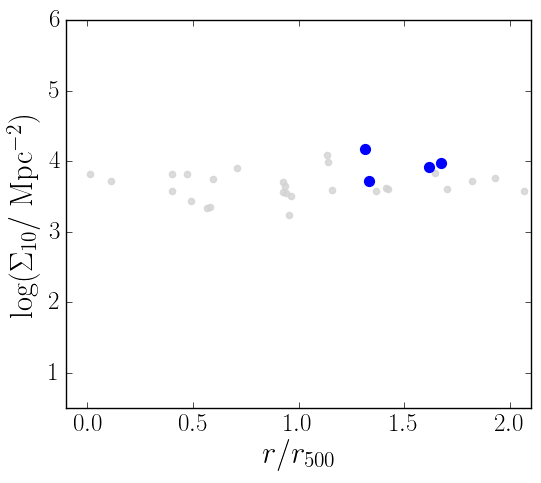

In [10]:
plt.scatter(members['r_center'],np.log10(members['Sigma_10_phot']),color='lightgray',alpha=0.8)
plt.scatter(cagn['r_center'],np.log10(cagn['Sigma_10_phot']),s=50, color='blue')
plt.xlim([-0.1,2.1])
plt.ylim([0.5,6])
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\log (\Sigma_{10}/~\mathrm{Mpc^{-2}})$')

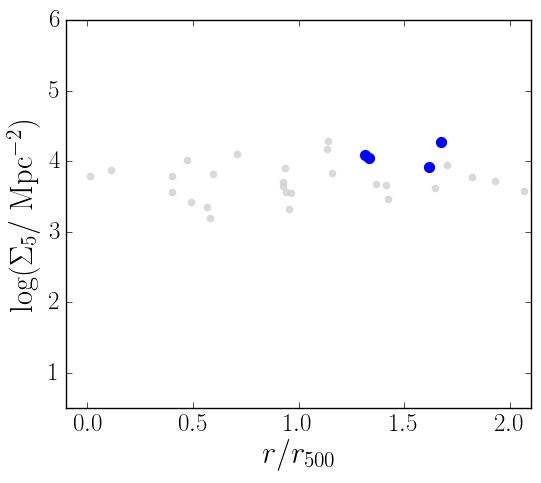

In [17]:
plt.scatter(members['r_center'],np.log10(members['Sigma_5_phot']),color='lightgray',alpha=0.8)
plt.scatter(cagn['r_center'],np.log10(cagn['Sigma_5_phot']),s=50, color='blue')
plt.xlim([-0.1,2.1])
plt.ylim([0.5,6])
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\log (\Sigma_{5}/~\mathrm{Mpc^{-2}})$')

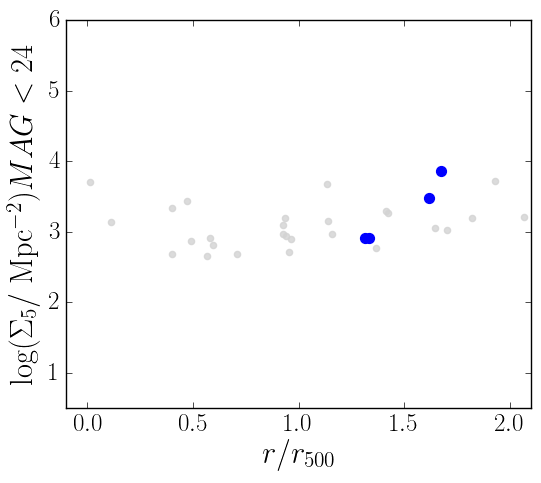

In [22]:
plt.scatter(members['r_center'],np.log10(members['Sigma_5_phot_MAG<24']),color='lightgray',alpha=0.8)
plt.scatter(cagn['r_center'],np.log10(cagn['Sigma_5_phot_MAG<24']),s=50, color='blue')
plt.xlim([-0.1,2.1])
plt.ylim([0.5,6])
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\log (\Sigma_{5}/~\mathrm{Mpc^{-2}}) MAG<24$')

In [11]:
mergedf['Sigma_10_phot'] = mergedf.apply(compute_Sigma10,axis=1,args=(mergedf,))

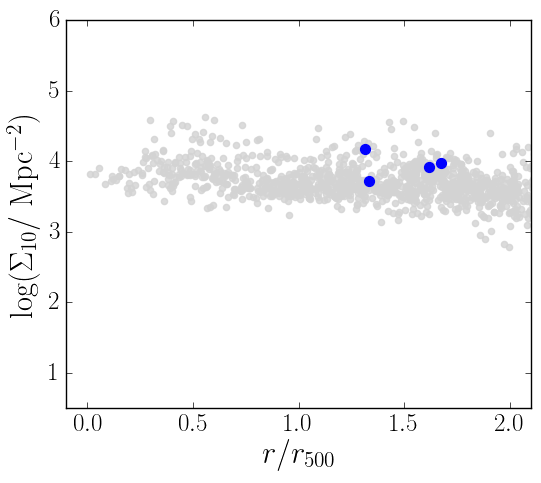

In [12]:
plt.scatter(mergedf['r_center'],np.log10(mergedf['Sigma_10_phot']),color='lightgray',alpha=0.8)
plt.scatter(cagn['r_center'],np.log10(cagn['Sigma_10_phot']),s=50, color='blue')
plt.xlim([-0.1,2.1])
plt.ylim([0.5,6])
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\log (\Sigma_{10}/~\mathrm{Mpc^{-2}})$')